In [13]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from numpy import linalg as la
import math
import cv2
from mtcnn.mtcnn import MTCNN

In [14]:
cropped = False
color = True
train_dir = "C:\\Users\\krish\\Desktop\\Krishna Work\\Face Detection and Recognition\\Face Datasets\\TrainDB\\FriendsDB (Classic) Classified"
test_dir = "C:\\Users\\krish\\Desktop\\Krishna Work\\Face Detection and Recognition\\Face Datasets\\TestDB\\FriendsDB (Classic)"
L = 75

In [15]:
def griddisplay(image_list):
    fig1, axes_array = plt.subplots(math.ceil((image_list.shape[0])/10), 10)
    fig1.set_size_inches(10,math.ceil((image_list.shape[0])/10))
    k=0
    for row in range(math.ceil((image_list.shape[0])/10)):
        for col in range(10):
            if k>=image_list.shape[0]:
                break
            if(math.ceil((image_list.shape[0])/10)>1):
                image_plot = axes_array[row][col].imshow(image_list[k].reshape(100,100),cmap=plt.cm.gray) 
                axes_array[row][col].axis('off')
            else:
                image_plot = axes_array[col].imshow(image_list[k].reshape(100,100),cmap=plt.cm.gray) 
                axes_array[col].axis('off')
            k = k+1
    plt.show()

1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Original Images


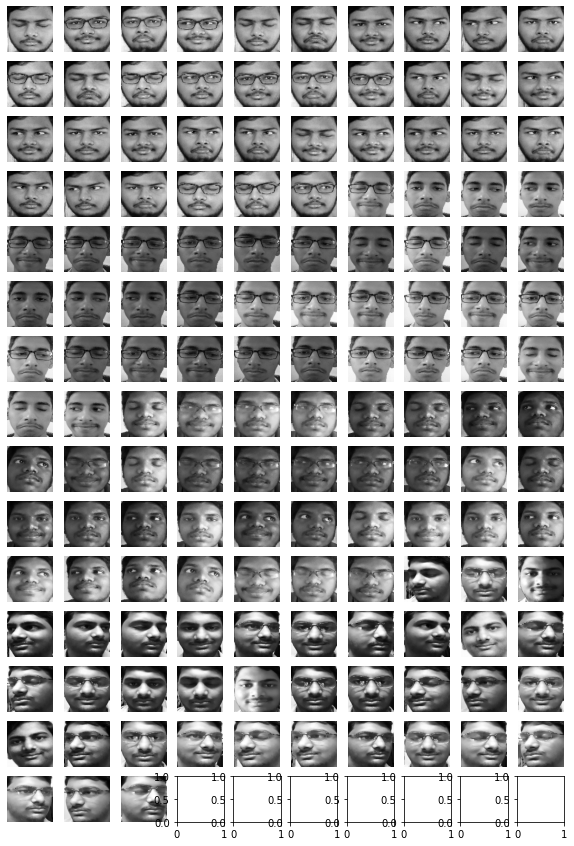

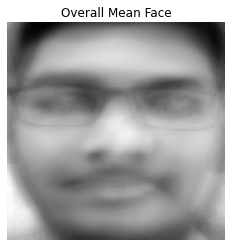

Mean of each class


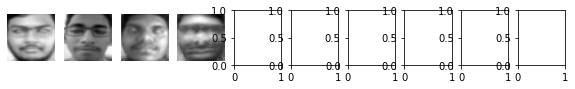

Zero mean faces


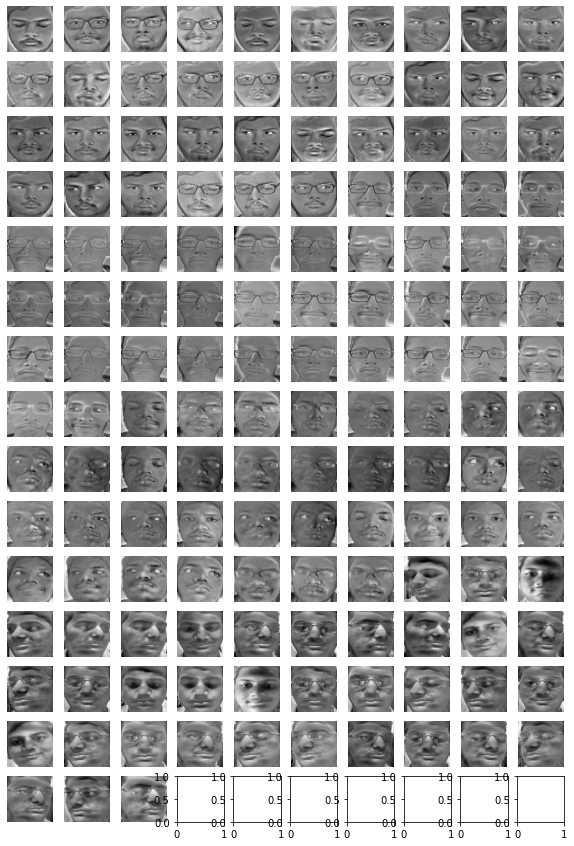

Fisher faces


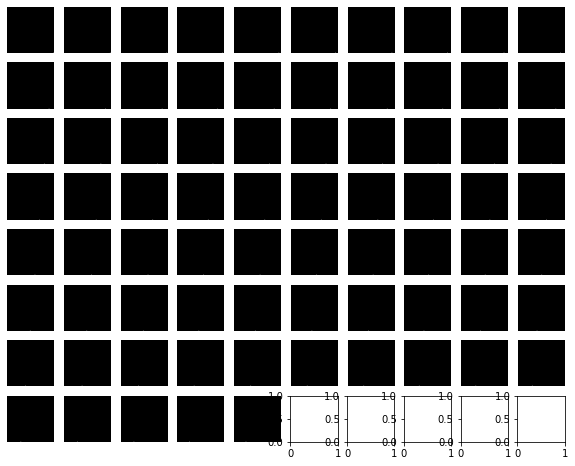

In [16]:
#Training

mtcnn_detector = MTCNN()
train_set = []
train_set_names = []
train_set_number = {}
subjects = os.listdir(train_dir)
for i in range(len(subjects)):
    person_id = subjects[i]
    subjectfiles = os.listdir(train_dir+"\\"+person_id)
    train_set_number[person_id] = 0
    for j in range(len(subjectfiles)):
        path = train_dir + '\\'+person_id+'\\'+subjectfiles[j]
        img  = np.array(cv2.imread(path))
        if not cropped:
            results = mtcnn_detector.detect_faces(img)
            if(len(results)==0):
                continue
            x,y,w,h = results[0]['box']
            x, y = abs(x), abs(y)
            if color:
                im2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                im2 = img
            train_set.append(cv2.resize(im2[y:y+h, x:x+w],(128,128),interpolation=cv2.INTER_LINEAR).flatten().astype(np.int64))
            train_set_number[person_id]+=1
            train_set_names.append(subjectfiles[j])
        else:
            if color:
                im2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                im2 = img
            train_set.append(cv2.resize(im2,(128,128),interpolation=cv2.INTER_LINEAR).flatten().astype(np.int64))
            train_set_number[person_id]+=1
            train_set_names.append(subjectfiles[j])

train_set = np.array(train_set)
print('Original Images')
griddisplay(train_set)

overall_mean = np.mean(train_set, axis = 0)
resized_mean = overall_mean.reshape(128,128)
plt.imshow(resized_mean,cmap=plt.cm.gray)
plt.axis('off')
plt.title('Overall Mean Face')
plt.show()

SW = np.zeros((16384,16384))
subjects = os.listdir(train_dir)
start = 0
classmeans = []
for i in range(len(subjects)):
    person_id = subjects[i]
    end = start+train_set_number[person_id]
    classmean = np.mean(train_set[start:end,:], axis = 0)
    classmeans.append(classmean)
    for j in range(start, end):
        train_set[j,:] = train_set[j,:] - classmean
        SW = SW + np.dot(train_set[j,:].T, train_set[j,:])
    start=end
classmeans = np.array(classmeans)

print('Mean of each class')
griddisplay(classmeans)

print('Zero mean faces')
griddisplay(train_set)

SB = np.zeros((16384,16384))
for i in range(len(subjects)):
    person_id = subjects[i]
    diff = classmeans[i] - overall_mean
    SB = SB + (train_set_number[person_id])*(np.dot(diff.T, diff))

J = np.dot(np.linalg.pinv(SW), SB)
w2, v2 = la.eigh(J)
Plda = np.zeros((16384, L))
for itr in range(L):
    Plda[:,itr] = v2[:,16383-itr]

print('Fisher faces')
griddisplay(Plda.T)

weights = np.zeros((train_set.shape[0],L))
for face_num in range(train_set.shape[0]):
    weights[face_num,:] = np.dot(train_set[face_num,:],Plda)

In [ ]:
#Testing

count = 0
threshold = 28000
correct = 0
for filename in os.listdir(test_dir):
    img = cv2.imread(test_dir+"\\"+filename)
    if not cropped:
        results = mtcnn_detector.detect_faces(img)
        if(len(results)==0):
            continue
        x,y,w,h = results[0]['box']
        x, y = abs(x), abs(y)
        if color:
            im2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            im2 = img
        img = cv2.resize(im2[y:y+h, x:x+w],(128,128),interpolation=cv2.INTER_LINEAR).flatten()
    else:
        if color:
            im2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            im2 = img
        img = cv2.resize(im2,(128,128),interpolation=cv2.INTER_LINEAR).flatten()
    imglda = (img - overall_mean)*Plda;
    distarray = np.zeros((train_set.shape[0],1));
    for i in range(train_set.shape[0]):
        distarray[i] = np.sum(np.abs(weights[i,:]-imglda));
    [result,indx]=[np.min(distarray),np.argmin(distarray)];
    if result < threshold and filename.split("_")[0]==train_set_names[indx].split("_")[0]:
        correct+=1
    count+=1
print(correct)
print((correct/count)*100)